In [1]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from net import Net
from dataset import Dataset
%matplotlib inline

In [2]:
batch_size = 8
image_size = 128
data_root = "./data"
ckpt_path = "./checkpoint/color_200.pth"

In [3]:
data  = Dataset(train=False,
                data_root=data_root,
                size=image_size)
loader = DataLoader(data,
                    batch_size=batch_size,
                    num_workers=1,
                    shuffle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

In [5]:
net.eval()
gt_rgb, pred_rgb = list(), list()
with torch.no_grad():
    for step, inputs in enumerate(loader):
        gt_gray = inputs[0].to(device)
        gt_ab   = inputs[1].to(device)
        
        pred_ab = net(gt_gray)

        gt_gray = gt_gray.detach().cpu().unsqueeze(1)
        gt_ab   = gt_ab.detach().cpu()
        pred_ab = pred_ab.detach().cpu()

        # construct the Lab image
        gt_lab   = torch.cat([gt_gray, gt_ab], dim=1)
        pred_lab = torch.cat([gt_gray, pred_ab], dim=1)

        gt_gray  = gt_gray.permute(0, 2, 3, 1).numpy()
        gt_lab   = gt_lab.permute(0, 2, 3, 1).numpy()
        pred_lab = pred_lab.permute(0, 2, 3, 1).numpy()
        
        # convert Lab to RGB space
        for gt, pred in zip(gt_lab, pred_lab):
            gt = gt.astype(np.float64)
            gt[:, :, :1] = np.clip(gt[:, :, :1]*100, 0, 100)
            gt[:, :, 1:] = gt[:, :, 1:]*255-128
            gt_rgb.append(lab2rgb(gt))
            
            pred[:, :, :1] = pred[:, :, :1] * 100
            pred[:, :, 1:] = pred[:, :, 1:] * 255 - 128
            pred = pred.astype(np.float64)
            pred_rgb.append(lab2rgb(pred))
        break # run only first batch

/home/nmhkahn/.venv3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/nmhkahn/.venv3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 13 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/nmhkahn/.venv3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/nmhkahn/.venv3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 16 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/nmhkahn/.venv3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out o

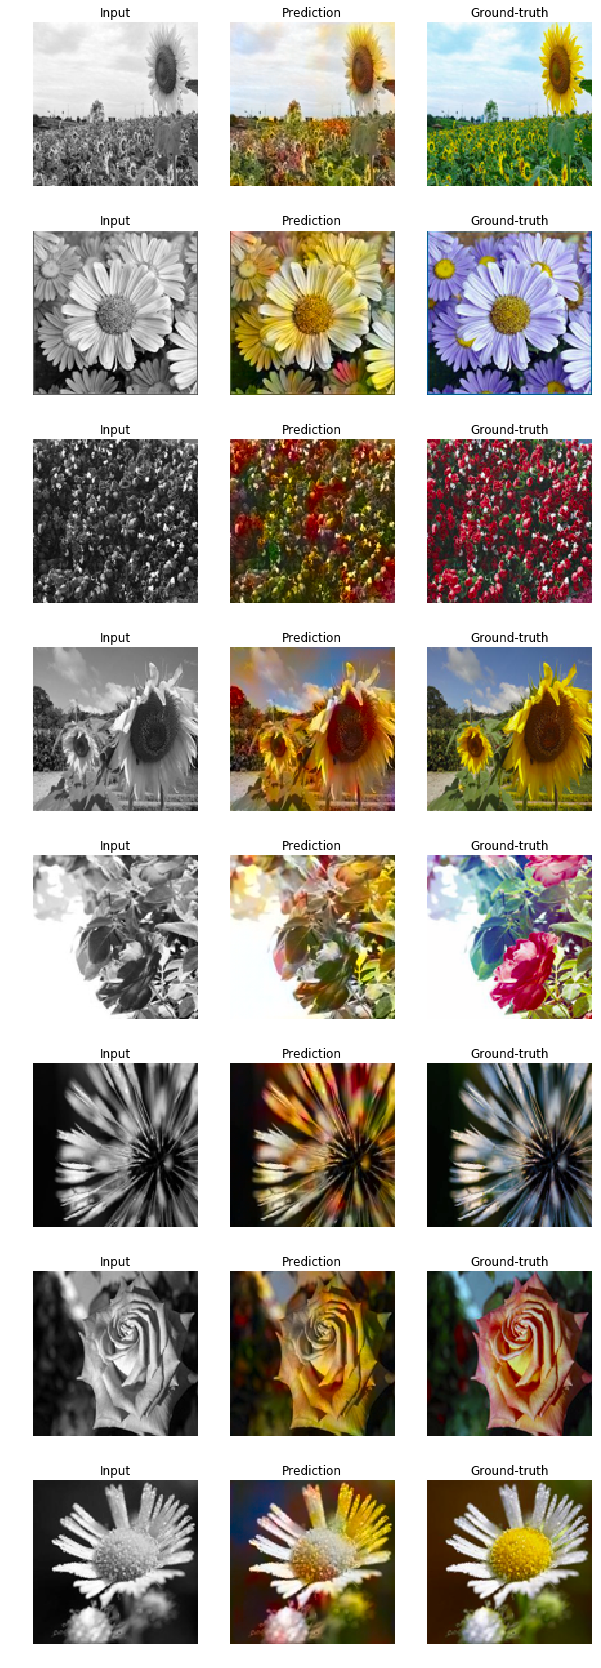

In [6]:
fig = plt.figure(figsize=(10, 30))

# visualize first batch
for i, (gray, gt, pred) in enumerate(zip(gt_gray, gt_rgb, pred_rgb)):
    ax1 = fig.add_subplot(batch_size, 3, i*3+1)
    ax1.set_title("Input")
    ax1.imshow(gray[:,:,0], cmap="gray")
    ax1.axis("off")
    
    ax2 = fig.add_subplot(batch_size, 3, i*3+2)
    ax2.set_title("Prediction")
    ax2.imshow(pred)
    ax2.axis("off")
    
    ax3 = fig.add_subplot(batch_size, 3, i*3+3)
    ax3.set_title("Ground-truth")
    ax3.imshow(gt)
    ax3.axis("off")